<a href="https://colab.research.google.com/github/dogepeng/aquaponics/blob/main/Aquaponics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cheat Sheet for 2023-2024 Aquaponics Research Machine Learning

In [ ]:
#IMPORTS

import urllib #Used to get data from Google Sheet
import torch #Standard pytorch libraries
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import random

device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

X TRAIN: torch.Size([800, 6])
X TEST: torch.Size([200, 6])
Y TRAIN: torch.Size([800, 1])
Y TEST: torch.Size([200, 1])


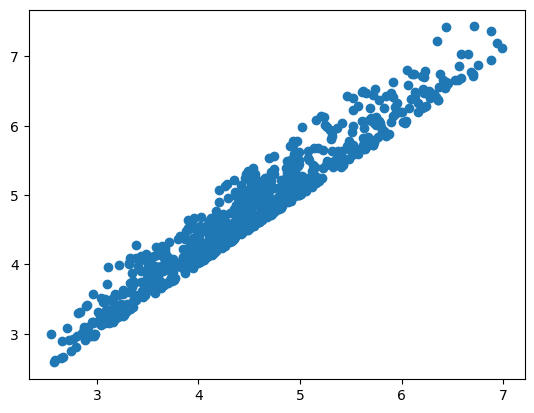

In [ ]:
#Pretend training data

import pandas
#morphometric_pred_data = pandas.read_csv('PretendShrimpDataPredMorph.csv') #TAGGED IMAGES
mass_pred_data = pandas.DataFrame(pandas.read_csv(urllib.request.urlopen("https://docs.google.com/spreadsheets/d/1fQ15_NWog8nHX8xlgX7efpMt83GuMLzDaH1mSWfeavs/export?format=csv"))).T[1:] #MEASUREMENTS

mass_pred_data_x_train = torch.tensor(np.array(mass_pred_data[:-1].T.head(800),dtype=np.float32))
mass_pred_data_x_test = torch.tensor(np.array(mass_pred_data[:-1].T.tail(200),dtype=np.float32))

mass_pred_data_y_train = torch.tensor(np.array(mass_pred_data[6:].T.head(800),dtype=np.float32))
mass_pred_data_y_test = torch.tensor(np.array(mass_pred_data[6:].T.tail(200),dtype=np.float32))

#Check that the data is in the right dimensions
print(f"X TRAIN: {mass_pred_data_x_train.size()}")
print(f"X TEST: {mass_pred_data_x_test.size()}")
print(f"Y TRAIN: {mass_pred_data_y_train.size()}")
print(f"Y TEST: {mass_pred_data_y_test.size()}")

import matplotlib.pyplot as plt


plt.scatter(mass_pred_data_x_train.T[:1].T,mass_pred_data_y_train)


In [ ]:
#DEFINING THE MODEL
class MassPredNeuralNetwork(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.predict = torch.nn.Linear(inputs,outputs)
    # self.predict = torch.nn.Linear(inputs, outputs)
    self.device = torch.device(device)
  #FORWARD
  def forward(self, x):
    mass_pred = self.predict(x)
    return mass_pred


In [ ]:
#CREATING THE TRAINING LOOP
def train(model, data_x, data_y, loss_fn, optimizer, epochs):
  #Set model to training mode
  model.train()
  #TRAINING
  for i in range(epochs):
    for (a,b) in enumerate(data_y):

      #Predict error (MEAN SQUARED ERROR BECAUSE REGRESSION)
      x,y = data_x[a].to(device), b.to(device)
      pred = model(x)
      loss = loss_fn(pred, y)
      diff = abs(pred-y)/y

      #Backpropagation
      optimizer.zero_grad()
      torch.set_grad_enabled(True)
      loss.backward()
      optimizer.step()




In [ ]:
#CREATING THE TESTING LOOP
def test(model, data_x, data_y, loss_fn):
  model.eval()
  total_loss, correct, big_correct, big_wrong, medium_wrong = 0, 0, 0, 0, 0 #Big correct means within 0.001 of the actual value, Big wrong means further than 10% from the value
  with torch.no_grad():
    for (x,y) in enumerate(data_y):
      x,y = data_x[x].to(device), y.to(device)
      prediction = model(x)
      loss = loss_fn(prediction, y).item()

      # Customized loss
      diff = abs(prediction-y)/y
      if diff > 0.1:
        big_wrong += 1
      #   loss += 1.2
      elif diff > 0.05 and diff <0.1:
        medium_wrong += 1
      #   loss += 0.2
      elif diff <= 0.05:
        correct += 1
      elif diff <= 0.01:
        big_correct += 1
      #   loss -= 0.9

      total_loss += loss

  average_loss = total_loss/len(data_y)
  print(f"Total Loss: {total_loss}")

  #RESULTS
  print(f"RESULTS: Number correct: {correct}, Percentage correct: {100*correct/len(data_y)}%, Average loss: {average_loss}, Big wrong: {big_wrong}, Medium wrong: {medium_wrong}")

In [ ]:
#TRAINING AND TESTING
from torch.nn import MSELoss, L1Loss
loss_fn = L1Loss()
model = MassPredNeuralNetwork(6,1).to(device)
optim = torch.optim.SGD(model.parameters(), lr = 0.0000000033)

epochs = 20
for i in range(epochs):
  print(f"Epoch: {i+1}")
  train(model, mass_pred_data_x_train, mass_pred_data_y_train, MSELoss(), optim, 5) #TODO BATCHING
  test(model, mass_pred_data_x_test, mass_pred_data_y_test, loss_fn)
  print("------------------------------------------------------------------------------")

Epoch: 1
Total Loss: 1396.8371953964233
RESULTS: Number correct: 0, Percentage correct: 0.0%, Average loss: 6.984185976982117, Big wrong: 200, Medium wrong: 0
------------------------------------------------------------------------------
Epoch: 2
Total Loss: 1395.686107158661
RESULTS: Number correct: 0, Percentage correct: 0.0%, Average loss: 6.978430535793304, Big wrong: 200, Medium wrong: 0
------------------------------------------------------------------------------
Epoch: 3
Total Loss: 1394.535674571991
RESULTS: Number correct: 0, Percentage correct: 0.0%, Average loss: 6.972678372859955, Big wrong: 200, Medium wrong: 0
------------------------------------------------------------------------------
Epoch: 4
Total Loss: 1393.3864340782166
RESULTS: Number correct: 0, Percentage correct: 0.0%, Average loss: 6.9669321703910825, Big wrong: 200, Medium wrong: 0
------------------------------------------------------------------------------
Epoch: 5
Total Loss: 1392.2381329536438
RESULTS: 

In [ ]:
#TESTING MODEL
import random
for i in range(2):
  b = []
  for p in range(200):
    counter = 0
    for i in range(100):
      random_val = random.choice(range(200))
      test_x, test_y = mass_pred_data_x_test[random_val].to(device), mass_pred_data_y_test[random_val].to(device)
      # print(test_x)
      with torch.no_grad():
        pred = model(test_x)
        a = 100*(abs(pred-test_y)/test_y)
        # print(a)
        if a>5:
          counter +=1
    b.append(100*counter/100)
    # print(f"Wrong: {b[p]}%")
  print(f"Average error: {sum(b)/len(b)}%")

Average error: 23.87%
Average error: 23.565%


In [ ]:
#INDEX CHECK
for i in range(5):
  m = random.choice(range(200))
  test_x, test_y = mass_pred_data_x_test[m], mass_pred_data_y_test[m]
  # print(test_x)

  with torch.no_grad():
    pred = model(test_x)
    print(f"Prediction: {round(pred.item(),2)}, Actual: {round(test_y.item(),2)}")

Prediction: 3.15, Actual: 3.63
Prediction: 4.02, Actual: 3.89
Prediction: 5.3, Actual: 5.04
Prediction: 4.75, Actual: 4.7
Prediction: 3.37, Actual: 3.36
